<a href="https://colab.research.google.com/github/AntonioBritoJunior/PDI/blob/main/trabalho_bogs1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

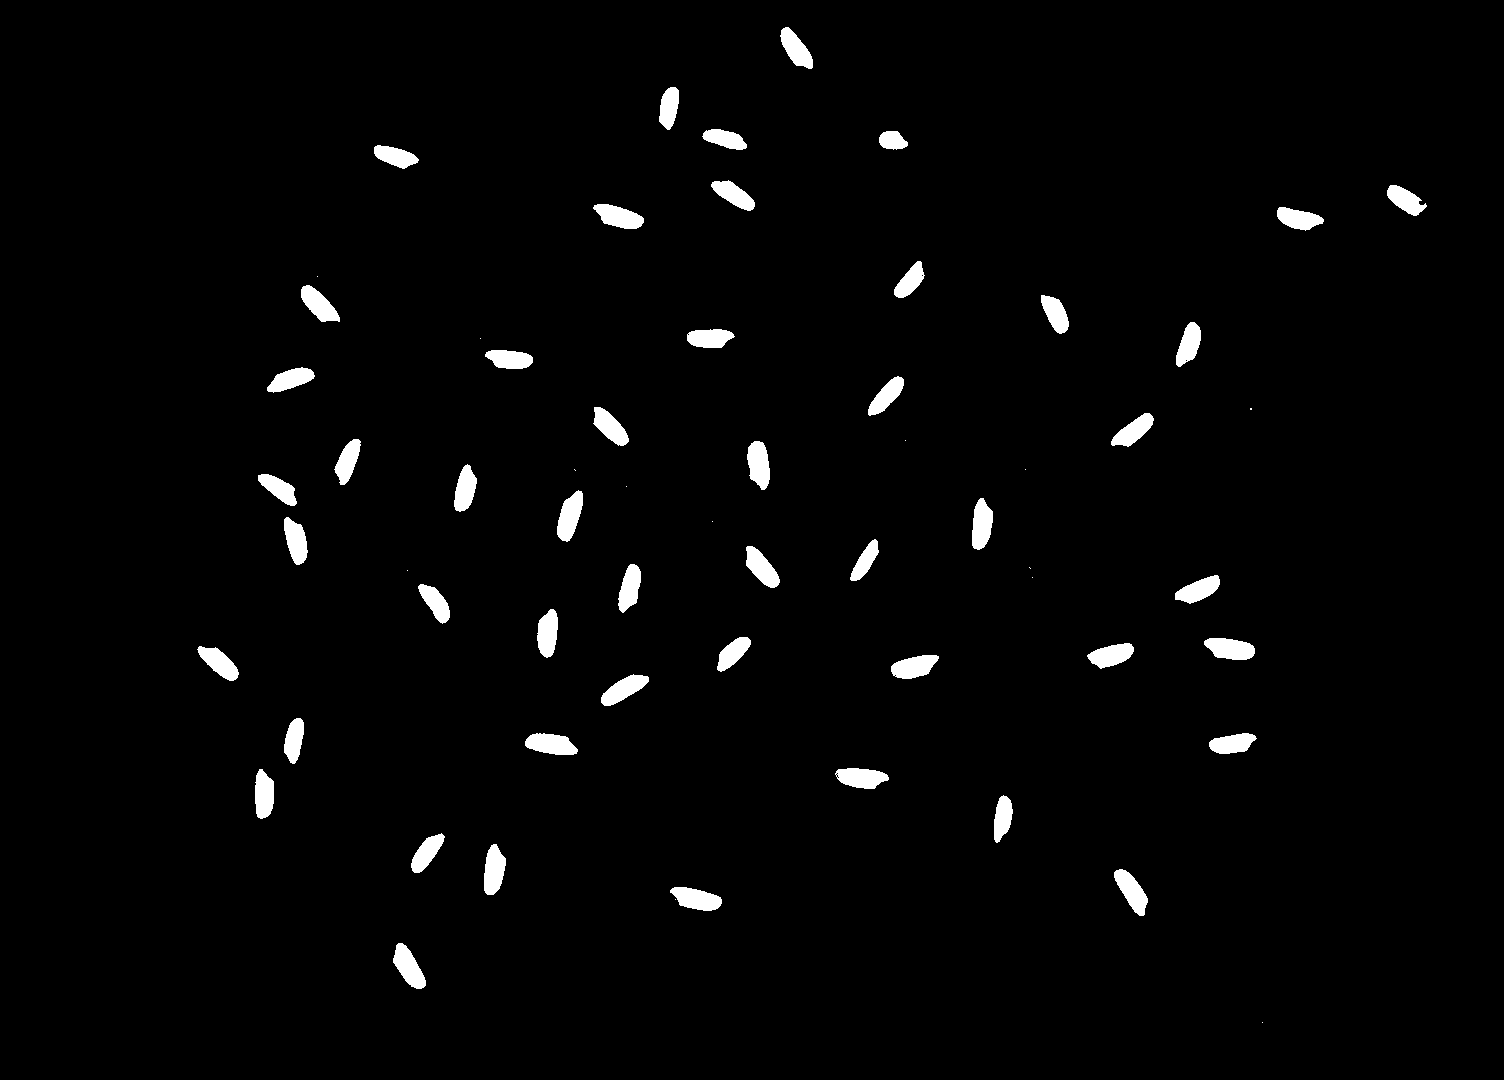

Tempo: 3.010026
49 componentes detectados.


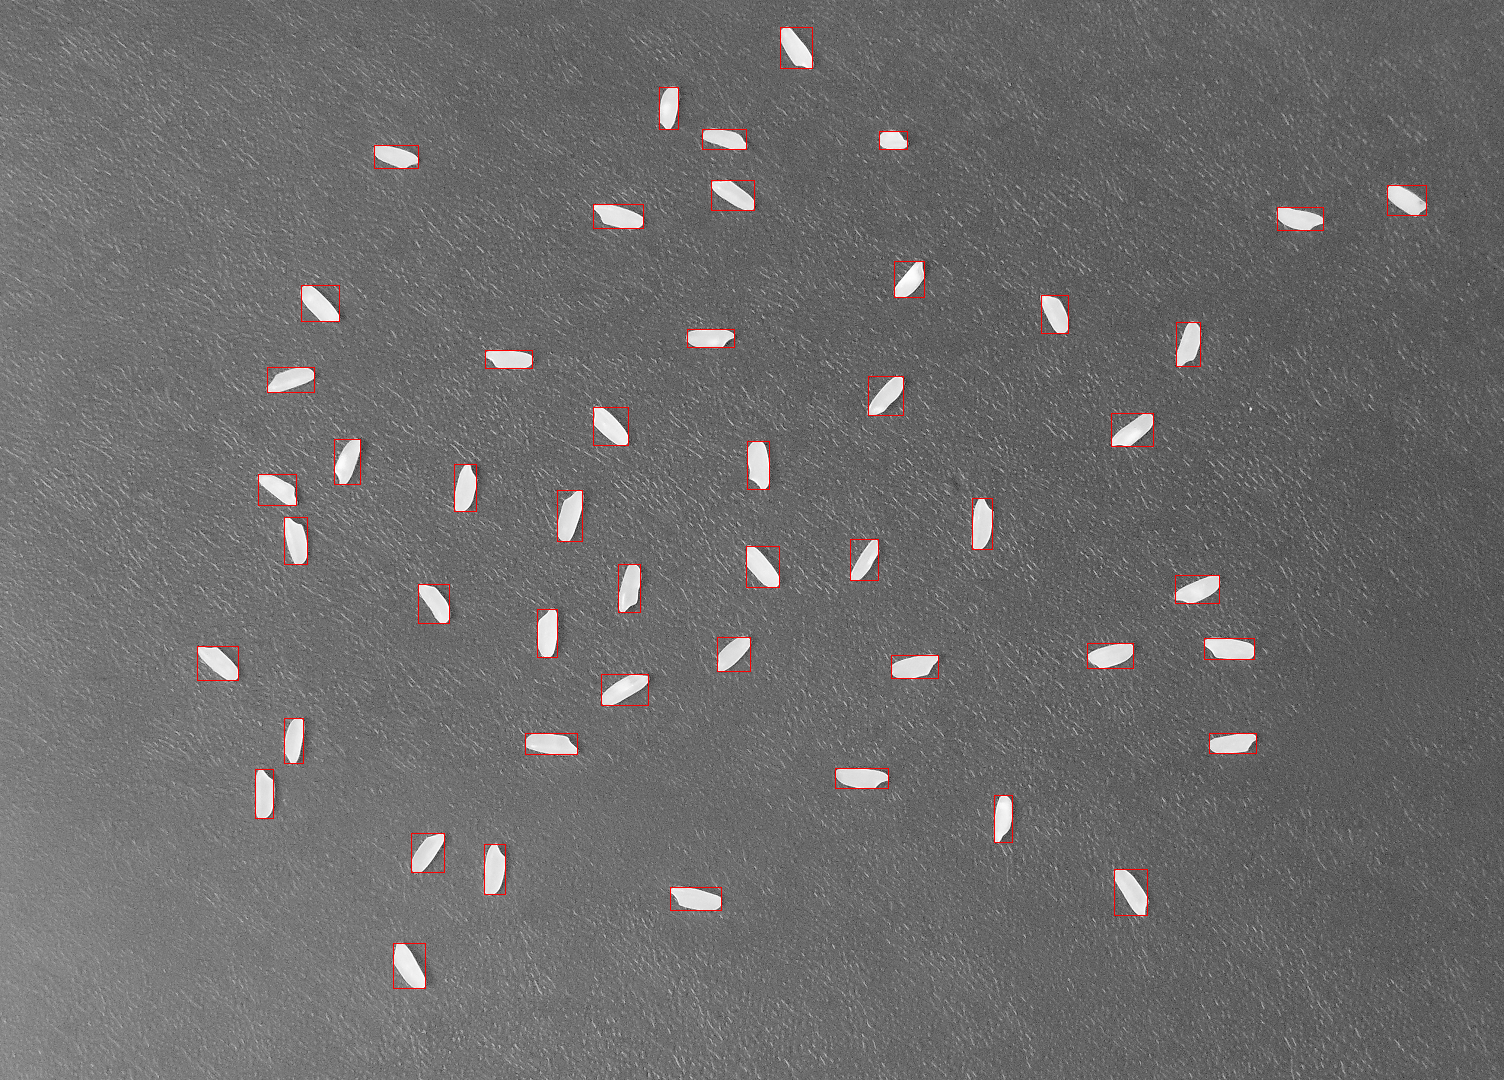

In [ ]:
#===============================================================================
# Exemplo: segmentação de uma imagem em escala de cinza.
#-------------------------------------------------------------------------------
# Autor: Bogdan T. Nassu
# Universidade Tecnológica Federal do Paraná
#===============================================================================

import sys
import timeit
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#===============================================================================

# INPUT_IMAGE =  'arroz.bmp'
INPUT_IMAGE =  'drive/MyDrive/Colab Notebooks/arroz.bmp'

# TODO: ajuste estes parâmetros!
NEGATIVO = False
THRESHOLD = 0.8
ALTURA_MIN = 15
LARGURA_MIN = 15
N_PIXELS_MIN = 100

#===============================================================================

def binariza (img, threshold):
    ''' Binarização simples por limiarização.

Parâmetros: img: imagem de entrada. Se tiver mais que 1 canal, binariza cada
              canal independentemente.
            threshold: limiar.
            
Valor de retorno: versão binarizada da img_in.'''

    # TODO: escreva o código desta função.
    # Dica/desafio: usando a função np.where, dá para fazer a binarização muito
    # rapidamente, e com apenas uma linha de código!
    rows, cols, channels = img.shape
    for row in range(rows):
      for col in range(cols):
          if img[row, col] > threshold:
            img[row, col] = 1
          else:
            img[row, col] = 0

    return img

#-------------------------------------------------------------------------------

def inunda(img, row, col, label, n_pixels, top, left, bottom, right):
  img[row, col] = label
  n_pixels = n_pixels + 1
  rows, cols, channels = img.shape

  # vizinho-8
  vizinhos = [(col-1,row),(col+1,row),(col-1,row-1),(col+1,row+1),
              (col-1,row+1),(col+1,row-1),(col,row-1),(col,row+1)]

  if top == -1: top = row
  elif top > row: top = row

  if bottom == -1: bottom = row
  elif bottom < row: bottom = row

  if left == -1: left = col
  elif left > col: left = col

  if right == -1: right = col
  elif right < col: right = col

  for vizinho in vizinhos:
    if 0 <= vizinho[0] < cols and 0 <= vizinho[1] < rows and img[vizinho[1], vizinho[0]] == 1:
      n_pixels, top, left, bottom, right = inunda(img, vizinho[1], vizinho[0], label, n_pixels, top, left, bottom, right) 

  return [n_pixels, top, left, bottom, right]


def rotula (img, largura_min, altura_min, n_pixels_min):
    '''Rotulagem usando flood fill. Marca os objetos da imagem com os valores
[0.1,0.2,etc].

Parâmetros: img: imagem de entrada E saída.
            largura_min: descarta componentes com largura menor que esta.
            altura_min: descarta componentes com altura menor que esta.
            n_pixels_min: descarta componentes com menos pixels que isso.

Valor de retorno: uma lista, onde cada item é um vetor associativo (dictionary)
com os seguintes campos:

'label': rótulo do componente.
'n_pixels': número de pixels do componente.
'T', 'L', 'B', 'R': coordenadas do retângulo envolvente de um componente conexo,
respectivamente: topo, esquerda, baixo e direita.'''

    # TODO: escreva esta função.
    # Use a abordagem com flood fill recursivo.

    label = 0.15
    comp_list = []

    rows, cols, channels = img.shape
    for row in range(rows):
      for col in range(cols):
        if img[row, col] == 1: 
          n_pixels = 0
          top = -1
          left = -1 
          bottom = -1
          right = -1
          n_pixels, top, left, bottom, right = inunda(img, row, col, label, n_pixels, top, left, bottom, right)
          if n_pixels >= n_pixels_min and abs(top - bottom) >= altura_min and abs(left - right) >= largura_min:
            comp = {
                "label" : label,
                "n_pixels" : n_pixels,
                "T" : top,
                "L" : left,
                "B" : bottom,
                "R" : right
            }
            comp_list.append(comp)
            label = label + 0.15

    return comp_list

    
#===============================================================================

def main ():

    sys.setrecursionlimit(1000000)

    # Abre a imagem em escala de cinza.
    img = cv2.imread (INPUT_IMAGE, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print ('Erro abrindo a imagem.\n')
        sys.exit ()

    # É uma boa prática manter o shape com 3 valores, independente da imagem ser
    # colorida ou não. Também já convertemos para float32.
    img = img.reshape ((img.shape [0], img.shape [1], 1))
    img = img.astype (np.float32) / 255

    # Mantém uma cópia colorida para desenhar a saída.
    img_out = cv2.cvtColor (img, cv2.COLOR_GRAY2BGR)

    # Segmenta a imagem.
    if NEGATIVO:
        img = 1 - img
    img = binariza (img, THRESHOLD)
    # cv2.imshow ('01 - binarizada', img)
    cv2_imshow (img * 255)
    cv2.imwrite ('01 - binarizada.png', img*255)

    start_time = timeit.default_timer ()
    componentes = rotula (img, LARGURA_MIN, ALTURA_MIN, N_PIXELS_MIN)
    n_componentes = len (componentes)
    print ('Tempo: %f' % (timeit.default_timer () - start_time))
    print ('%d componentes detectados.' % n_componentes)

    # Mostra os objetos encontrados.
    for c in componentes:
        cv2.rectangle (img_out, (c ['L'], c ['T']), (c ['R'], c ['B']), (0,0,1))
    

    # cv2.imshow ('02 - out', img_out)
    cv2_imshow (img_out * 255)
    cv2.imwrite ('02 - out.png', img_out*255)
    cv2.waitKey ()
    cv2.destroyAllWindows ()


if __name__ == '__main__':
    main ()

#===============================================================================
